## **U-Net training process**

In [1]:
import json
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# custom functions imported from src
from src.modeling import load_patches, class_counts_to_weights, compile_unet
from src.plot import plot_learning_history

2025-01-23 09:17:10.367984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 09:17:10.368047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 09:17:10.497387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 09:17:10.806174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


We are training our U-Net model from scratch, therefore we set a seed at the beginning to ensure reproducibility in the way model layers are initialized. For more information, visit https://keras.io/examples/keras_recipes/reproducibility_recipes/. 

In [2]:
seed=100
keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()
# all seeds used: 100, 10, 2, 43301, 52647, 69736, 71747, 77395, 8925, 9417

### **Set configurations**

In [3]:
# set your workspace and data files
root_dir = "/home/lenkne/shared/StLouisRiver/"
data_dir = root_dir + "st_louis_augment_overlap_128/"
data_stats_filepath = data_dir + "augment_stats.json"
model_filepath = root_dir + f"model-seed-{seed}.keras"

# define model parameters
n_epochs = 100
n_classes = 8 # 7 actual land cover clases and unlabeled backgroud
patch_height = 256
patch_width  = 256
patch_channels = 4 # we use 4-band NAIP imagery
batch_size = 64
learning_rate = 0.001
backbone = "resnet34"

We can configure the model with class weights to give more attention to the minority classes. This allows us to balance under-represented (such as "rocky") and over-represented (such as "water") classes in the training set. Remember: we have sparsely labeled training data, so in this process we also set the weight of the "unlabeled background" to 0 to make sure the model ignores it.

In [4]:
# load pre-computed class statistics
class_feature_counts = json.load(open(data_stats_filepath))["numFeaturesPerClass"]["train"]
class_weights = class_counts_to_weights(class_feature_counts=class_feature_counts, n_classes=n_classes, sparse=True)
print ("Distribution of feature counts by class:", class_feature_counts)
print ("Resulting class weights:", class_weights)

Distribution of feature counts by class: {'5': 1010, '6': 265, '7': 861, '1': 589, '3': 413, '4': 543, '2': 300}
Resulting class weights: [0, 6.758913412563667, 13.27, 9.639225181598063, 7.331491712707182, 3.9415841584158415, 15.022641509433962, 4.623693379790941]


### **Load training data**

We load the pre-processed training dataset that consists of 256 by 256 patches with image arrays and corresponding label arrays.

In [5]:
image_patches = load_patches(data_dir, subset="train", which="images", onehot=False)
print ("Image dataset shape:", image_patches.shape)

Image dataset shape: (3471, 256, 256, 4)


In [6]:
label_patches = load_patches(data_dir, subset="train", which="labels", onehot=True)
print ("Label dataset shape:", label_patches.shape)

Label dataset shape: (3471, 256, 256, 8)


Note that the initial split into train and test was accomplished at the polygon level during transformation of the polygons and imagery into patches. Here we further split the train dataset into train and validation.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    image_patches, label_patches, train_size=0.8, random_state=42
)
print ("Train image dataset shape:", X_train.shape)
print ("Val image dataset shape:", X_val.shape)

Train image dataset shape: (2776, 256, 256, 4)
Val image dataset shape: (695, 256, 256, 4)


### **Compile a model**

In [8]:
model = compile_unet(
    backbone=backbone, patch_height=patch_height, patch_width=patch_width,
    patch_channels=patch_channels, n_classes=n_classes, activation="softmax",
    class_weights=class_weights, learning_rate=learning_rate)
checkpoint = ModelCheckpoint(model_filepath, monitor="val_loss", save_best_only=True)
callbacks = [checkpoint]

2025-01-23 09:22:14.645812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:4c:00.0, compute capability: 8.6


### **Train a model**

This is often the longest part of the process and can run efficiently when using GPUs.

In [9]:
%%time
history=model.fit(
    X_train, y_train,
    epochs=n_epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/100


2025-01-23 09:22:36.455688: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-01-23 09:22:38.305258: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-23 09:22:38.308056: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-23 09:22:38.308073: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-23 09:22:38.308141: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-01-23 09:22

 1/87 [..............................] - ETA: 30:21 - loss: 0.2131 - iou_score: 0.0908

2025-01-23 09:22:50.212188: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-23 09:22:50.263947: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



87/87 [==============================] - 42s 244ms/step - loss: 0.0723 - iou_score: 0.2927 - val_loss: 0.3712 - val_iou_score: 0.1623
Epoch 2/100
87/87 [==============================] - 18s 209ms/step - loss: 0.0426 - iou_score: 0.3864 - val_loss: 0.0433 - val_iou_score: 0.3702
Epoch 3/100
87/87 [==============================] - 17s 191ms/step - loss: 0.0369 - iou_score: 0.4337 - val_loss: 0.3941 - val_iou_score: 0.3593
Epoch 4/100
87/87 [==============================] - 18s 205ms/step - loss: 0.0323 - iou_score: 0.4614 - val_loss: 0.0696 - val_iou_score: 0.5312
Epoch 5/100
87/87 [==============================] - 17s 192ms/step - loss: 0.0312 - iou_score: 0.4761 - val_loss: 0.0507 - val_iou_score: 0.4479
Epoch 6/100
87/87 [==============================] - 17s 200ms/step - loss: 0.0291 - iou_score: 0.4856 - val_loss: 0.0453 - val_iou_score: 0.4744
Epoch 7/100
87/87 [==============================] - 17s 197ms/step - loss: 0.0273 - iou_score: 0.5106 - val_loss: 0.0762 - val_iou_scor

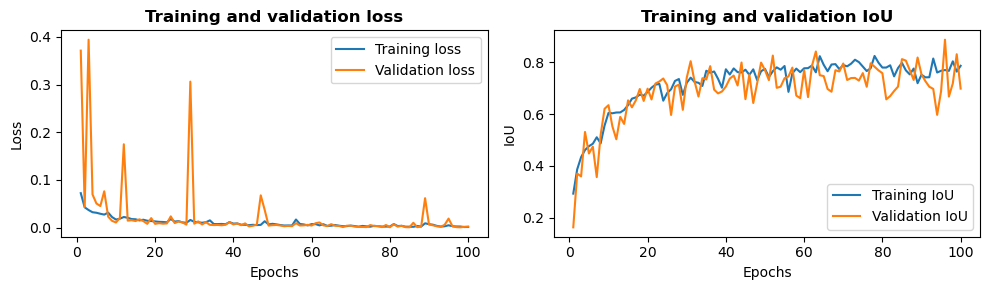

In [10]:
plot_learning_history(history)